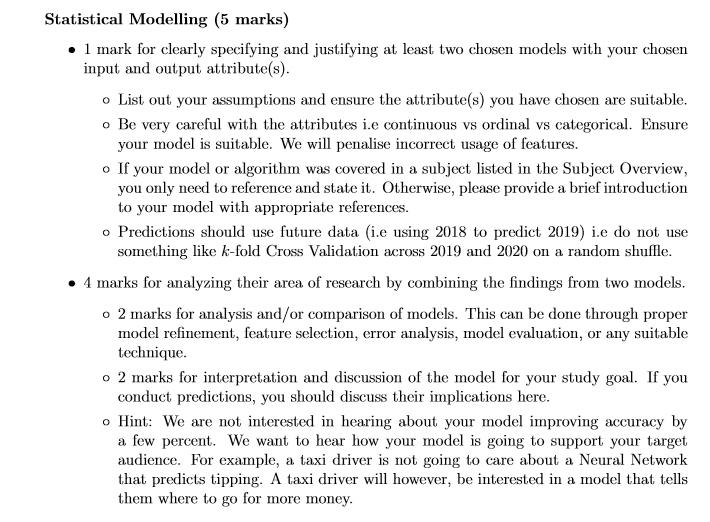

In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC") # fix timestamps loaded by spark
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/19 01:30:44 WARN Utils: Your hostname, DESKTOP-SATV84A resolves to a loopback address: 127.0.1.1; using 172.26.254.29 instead (on interface eth0)
23/08/19 01:30:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 01:30:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Modelling

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
import numpy

#df = spark.read.parquet('../data/curated/combined.parquet')

df = pd.read_parquet('../data/curated/combined_imputed.parquet')

In [4]:
# make separate model for airports that doesn't use external dataset predictors
df = df.drop(['avg_usd_per_1/5_mile', 'avg_usd_per_minute', 'number_of_trips_here', 'number_of_trips_nyc'], axis=1)

df_airports = df.loc[df['locationid'].isin([1, 132, 138])].drop(['year'], axis=1) 

df_city = df.loc[~df['locationid'].isin([1, 132, 138])].drop(['year'], axis=1) 

In [5]:
# remove external data for airports
df_airports = df_airports.iloc[:,:8]

In [6]:
df_airports.loc[df_airports['month'] != 11]['zone_profitability']

911       468.588977
957       461.583389
977       458.877820
1015      453.099577
1027      451.902219
             ...    
331628      2.075387
331886      2.013258
332137      1.941188
332355      1.848788
332566      1.618686
Name: zone_profitability, Length: 7945, dtype: float64

In [8]:
df_airports = pd.concat([pd.get_dummies(df_airports[['locationid', 'month', 'day_of_month', 'hour', 'day_of_week']].astype('category')), df_airports.drop(['locationid', 'month', 'day_of_month', 'hour', 'day_of_week'], axis=1)], axis=1)

In [9]:
df_airports.head()

,locationid_1,locationid_132,locationid_138,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,is_weekday,is_public_holiday,zone_profitability
911,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,468.588977
957,False,True,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,True,461.583389
977,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,458.877820
1015,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,453.099577
1027,False,True,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,True,451.902219


In [10]:
df_city = pd.concat([pd.get_dummies(df_city[['locationid', 'month', 'day_of_month', 'hour', 'day_of_week']].astype('category')), df_city.drop(['locationid', 'month', 'day_of_month', 'hour', 'day_of_week'], axis=1)], axis=1)

In [11]:
df_city.head()

,locationid_2,locationid_3,locationid_4,locationid_5,locationid_6,locationid_7,locationid_8,locationid_9,locationid_10,locationid_11,...,drive_%,carpool_%,transit_%,walk_%,work_at_home_%,avg_commute_mins,private_work_%,public_work_%,self_employed_%,unemployment_%
0,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
1,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
2,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
3,False,False,False,False,False,False,False,False,False,False,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575
4,False,False,False,False,False,False,False,False,False,False,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575


In [12]:
x_train_airports = df_airports.loc[df_airports['month_11'] != True].drop(['zone_profitability', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], axis=1)
x_test_airports = df_airports.loc[df_airports['month_11'] == True].drop(['zone_profitability', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], axis=1)

y_train_airports = df_airports.loc[df_airports['month_11'] != True]['zone_profitability']
y_test_airports = df_airports.loc[df_airports['month_11'] == True]['zone_profitability']



In [13]:
display(x_train_airports.head())

display(y_train_airports.head())

display(x_test_airports.head())

display(y_test_airports.head())

,locationid_1,locationid_132,locationid_138,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,...,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,is_weekday,is_public_holiday
911,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
957,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,True
977,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1015,False,True,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1027,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,True


911     468.588977
957     461.583389
977     458.877820
1015    453.099577
1027    451.902219
Name: zone_profitability, dtype: float64

,locationid_1,locationid_132,locationid_138,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,...,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,is_weekday,is_public_holiday
242053,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
242501,False,True,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
242620,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
242627,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
242656,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


242053    691.728187
242501    553.282844
242620    524.920092
242627    524.504918
242656    519.954852
Name: zone_profitability, dtype: float64

In [15]:
x_train_city = df_city.loc[df_city['month_11'] != True].drop(['zone_profitability', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], axis=1)
x_test_city = df_city.loc[df_city['month_11'] == True].drop(['zone_profitability', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], axis=1)

y_train_city = df_city.loc[df_city['month_11'] != True]['zone_profitability']
y_test_city = df_city.loc[df_city['month_11'] == True]['zone_profitability']


In [16]:
display(x_train_city.head())

display(y_train_city.head())

display(x_test_city.head())

display(y_test_city.head())

,locationid_2,locationid_3,locationid_4,locationid_5,locationid_6,locationid_7,locationid_8,locationid_9,locationid_10,locationid_11,...,drive_%,carpool_%,transit_%,walk_%,work_at_home_%,avg_commute_mins,private_work_%,public_work_%,self_employed_%,unemployment_%
0,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
1,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
2,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.25,30.750,30.70,12.916667,23.15,82.266667,5.333333,11.450,3.450
3,False,False,False,False,False,False,False,False,False,False,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575
4,False,False,False,False,False,False,False,False,False,False,...,4.250000,0.00,21.975,52.85,12.875000,40.25,87.650000,2.925000,9.425,2.575


0    989.145415
1    986.027285
2    978.373302
3    978.023633
4    977.043139
Name: zone_profitability, dtype: float64

,locationid_2,locationid_3,locationid_4,locationid_5,locationid_6,locationid_7,locationid_8,locationid_9,locationid_10,locationid_11,...,drive_%,carpool_%,transit_%,walk_%,work_at_home_%,avg_commute_mins,private_work_%,public_work_%,self_employed_%,unemployment_%
241776,False,False,False,False,False,False,False,False,False,False,...,3.766667,0.166667,56.816667,24.583333,7.450000,28.083333,84.850000,6.000000,9.100,6.750
241777,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.250000,30.750000,30.700000,12.916667,23.150000,82.266667,5.333333,11.450,3.450
241778,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.250000,30.750000,30.700000,12.916667,23.150000,82.266667,5.333333,11.450,3.450
241779,False,False,False,False,False,False,False,False,False,False,...,4.250000,0.000000,21.975000,52.850000,12.875000,40.250000,87.650000,2.925000,9.425,2.575
241780,False,False,False,False,False,False,False,False,False,False,...,12.183333,2.250000,30.750000,30.700000,12.916667,23.150000,82.266667,5.333333,11.450,3.450


241776    1824.970219
241777    1063.197972
241778    1056.853923
241779    1037.042491
241780    1030.352531
Name: zone_profitability, dtype: float64

In [17]:
x_train_city.columns

Index(['locationid_2', 'locationid_3', 'locationid_4', 'locationid_5',
       'locationid_6', 'locationid_7', 'locationid_8', 'locationid_9',
       'locationid_10', 'locationid_11',
       ...
       'drive_%', 'carpool_%', 'transit_%', 'walk_%', 'work_at_home_%',
       'avg_commute_mins', 'private_work_%', 'public_work_%',
       'self_employed_%', 'unemployment_%'],
      dtype='object', length=337)

In [18]:
x_train_airports.columns

Index(['locationid_1', 'locationid_132', 'locationid_138', 'day_of_month_1',
       'day_of_month_2', 'day_of_month_3', 'day_of_month_4', 'day_of_month_5',
       'day_of_month_6', 'day_of_month_7', 'day_of_month_8', 'day_of_month_9',
       'day_of_month_10', 'day_of_month_11', 'day_of_month_12',
       'day_of_month_13', 'day_of_month_14', 'day_of_month_15',
       'day_of_month_16', 'day_of_month_17', 'day_of_month_18',
       'day_of_month_19', 'day_of_month_20', 'day_of_month_21',
       'day_of_month_22', 'day_of_month_23', 'day_of_month_24',
       'day_of_month_25', 'day_of_month_26', 'day_of_month_27',
       'day_of_month_28', 'day_of_month_29', 'day_of_month_30',
       'day_of_month_31', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'day_of_w

In [56]:
x_test_airports

,locationid_1,locationid_132,locationid_138,day_of_month_1,day_of_month_2,day_of_month_3,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,...,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,is_weekday,is_public_holiday
242053,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
242501,False,True,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
242620,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
242627,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
242656,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286315,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
286342,False,True,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
286614,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
287423,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


## Airport Linear Regression

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [102]:
lr_airports = LinearRegression()
lr_airports.fit(x_train_airports, y_train_airports)
y_pred = lr_airports.predict(x_test_airports)

k = len(x_train_airports.columns)
n = x_train_airports.shape[0]
r2 = r2_score(y_train_airports, lr_airports.predict(x_train_airports))
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - k - 1))

print('===== FULL MODEL =====')
print(f'TRAIN R2: {r2}')
print(f'TRAIN ADJUSTED R2: {adj_r2}')
print(f'TEST R2: {r2_score(y_test_airports, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test_airports, y_pred, squared=False)}')
print(f'MAE: {mean_absolute_error(y_test_airports, y_pred)}')
print(f'k: {k}')

===== FULL MODEL =====
TRAIN R2: 0.5824932091251053
TRAIN ADJUSTED R2: 0.5789419897536925
TEST R2: 0.5337972887320176
RMSE: 65.14159960947113
MAE: 46.195450732897164
k: 67


## City Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
lr_city = LinearRegression()
lr_city.fit(x_train_city, y_train_city)
y_pred = lr_city.predict(x_test_city)

k = len(x_train_city.columns)
n = x_train_city.shape[0]
r2 = r2_score(y_train_city, lr_city.predict(x_train_city))
adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - k - 1))

print('===== FULL MODEL =====')
print(f'TRAIN R2: {r2}')
print(f'TRAIN ADJUSTED R2: {adj_r2}')
print(f'TEST R2: {r2_score(y_test_city, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test_city, y_pred, squared=False)}')
print(f'MAE: {mean_absolute_error(y_test_city, y_pred)}')
print(f'k: {k}')

===== FULL MODEL =====
TRAIN R2: 0.6392148593845841
TRAIN ADJUSTED R2: 0.6387781315501185
TEST R2: 0.6166559672292875
RMSE: 84.45893876293204
MAE: 55.31711233340048
k: 337
